In [3]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('human.json')
editor.run()

File saved as: human.json


multiplier: 0.8


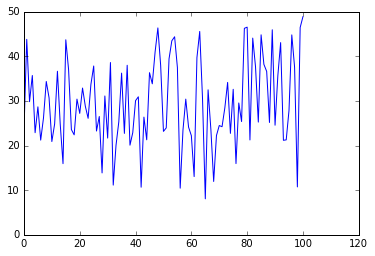

File loaded: human.json


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_r, K_s)
from Box2D.b2 import pi
from engine import Engine
from time import sleep

# train your model to (hopefully) walk by running this cell
FILE = 'human.json'

TIMESTEPS = 120 # timesteps per episode

# Physics engine and window
LOWER_LIM = -.2 * np.pi
UPPER_LIM = .2 * np.pi
LIMIT = True

ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0
engine = Engine(caption='Train', width=800, height=600, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0.0)

engine.load(FILE)

# Add floor
engine.add_static_body(p=(engine.width/2, engine.height-10), size=(engine.width, 10))

# Features
ENCODING_SIZE = 32 # buckets for body angles

def features(time_step=0):
    f = []

    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f += [a]
            
    #f += [float(time_step/TIMESTEPS * 2.0 - 1.0)]
    #f += [np.sin(time_step * 2.0)]
    #f += [np.sin(time_step)]
    #f += [np.sin(time_step/2.0)]
            
    #for j in engine.world.joints:
    #    f.append(j.motorSpeed)
                
    return np.array([f])
    
def body_position():
    avg = np.zeros([2])
    cnt = 0
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
            cnt += 1
    avg /= cnt
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])

body_count = len(engine.world.bodies) - 1
joint_count = len(engine.world.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

rs = []
avg_r = 0.0
total_r = 0.0
max_r = float('-inf')

multiplier = .8

HIDDEN = 256
best_W1 = None
best_W2 = None
W1 = None
W2 = None

def init_W():
    global best_W1, best_W2, W1, W2
    best_W1 = np.random.randn(features().shape[1], HIDDEN) * 1.0
    best_W2 = np.random.randn(HIDDEN, joint_count) * 1.0

    W1 = best_W1.copy()
    W2 = best_W2.copy()
    
init_W()

def relu(x):
    return x * (x > 0)

def dropout_relu(x, percent):
    x *= np.random.binomial([np.ones((x.shape[0], x.shape[1]))],1-percent)[0] * (1.0/(1-percent))
    return relu(x)

def act_W(features, speedup):
    z1 = features.dot(W1) if speedup else features.dot(best_W1)
    h1 = relu(z1)
    z2 = h1.dot(W2) if speedup else h1.dot(best_W2)
    z2 = np.tanh(z2)
    #z2 += np.random.randn(z2.shape[0], z2.shape[1]) * 0.1
    
    for i, j in enumerate(engine.world.joints):
        j.motorSpeed = z2[0, i]

speedup = False
running = True
while running:
    
    # train
    clear_output(wait=True)
    print('multiplier: {}'.format(np.round(multiplier, 2)))
    
    rs.append(total_r)
    
    fig = plt.plot(rs, 'b')
    plt.plot([0, len(rs)], [0, 0], 'r')
    plt.show()

    if total_r > max_r:
        max_r = total_r
        # save this model
        print('new best')
        best_W1 = W1.copy()
        best_W2 = W2.copy()

    W1 = best_W1.copy() * .8 + np.random.randn(best_W1.shape[0], best_W1.shape[1]) * multiplier
    W2 = best_W2.copy() * .8 + np.random.randn(best_W2.shape[0], best_W2.shape[1]) * multiplier
    
    if len(rs) > 100:
        rs = rs[1:]

    # timesteps
    t = 0
    total_r = 0.0
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    set_position((engine.width/2, engine.height/2))
    engine.step_physics(10)
    for b in engine.world.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
        
    
    last_p = body_position()
    
    reset = False
    while not reset:
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_r]:
                    init_W()
                elif k[K_RIGHT]:
                    multiplier += 0.1
                elif k[K_LEFT]:
                    multiplier -= 0.1
                elif k[K_s]:
                    speedup = not speedup
                multiplier = max(min(multiplier, 3), 0)
        
        act_W(features(t), speedup)
        
        # step physics engine n times
        for i in range(5):
            engine.step_physics(1)
            if not speedup:
                engine.render()
                engine.clock_tick()
        
        
        # reward
        new_p = body_position()
        
        reward = (engine.height - new_p[1]) / engine.height # stay high
        #reward += new_p[0] / engine.width
        
        total_r += reward
        
        avg_r += .001 * (reward - avg_r)
        #rs.append(avg_r)
                             
        if t > TIMESTEPS:
            reset = True
        
        if not speedup:
            engine.render()
            engine.clock_tick()

        # prepare for next rounds
        last_p = body_position()
        t += 1

        if last_p[0] > engine.width-50.0 or last_p[0] < 50.0:
            reset = True
            engine.render()
            engine.clock_tick()

engine.close()